In [1]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import torch
import cv2
from torchsummary import summary
from torch.utils.data import DataLoader
from PIL import Image
from dataloader import WHU
from utils import dataset_split
from torchvision import transforms
from model import Segmentor
from utils import  plot
from engine import train_val , test , matching

Splitting dataset into train/test/val --> 280/60/60

In [2]:
train_dir = "../Datasets/WHU-Bldg/dataset/train"
val_dir = "../Datasets/WHU-Bldg/dataset/val"
test_dir = "../Datasets/WHU-Bldg/dataset/test"

Checking the effect of downsizing the images

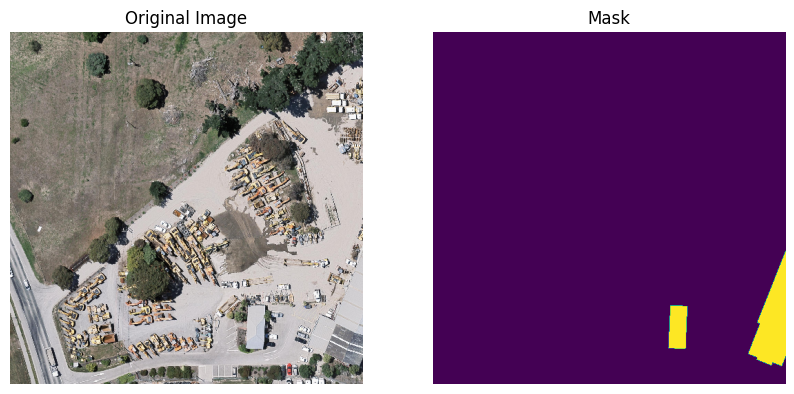

In [3]:
index = 2
# Open the original image
image = Image.open(os.path.join(train_dir,f"Images/{index}.png")).convert("RGB")

trans = transforms.Compose([
    transforms.Resize((512, 512))  # Use a smaller size to see the downsizing effect
])

# Apply the transformation
image_2 = Image.open(os.path.join(train_dir,f"Masks/{index}.png"))

image = np.array(image)
image_2 = np.array(image_2)


fig , axs = plt.subplots(nrows= 1 , ncols=2 , figsize = (10,10))
axs[0].imshow(image)
axs[0].set_title("Original Image")
axs[0].set_axis_off()
axs[1].imshow(image_2 , cmap = 'viridis')
axs[1].set_title("Mask")
axs[1].set_axis_off()
plt.show()

In [11]:
#HYPERPARAMETERS
BATCH_SIZE = 6
device = 'cuda' if torch.cuda.is_available() else 'cpu'
lr = 0.001
scheduler = "exponential"
epochs = 200

In [5]:
# for massachuesstes dataset

train_dataset = WHU(parent_dir="../Datasets/Massachusetts/png/Train")

val_dataset = WHU(parent_dir="../Datasets/Massachusetts/png/Val")

test_dataset = WHU(parent_dir="../Datasets/Massachusetts/png/Test")

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True , drop_last = True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False , drop_last=True)
len(train_loader) , len(test_loader) , len(val_loader)

(69, 5, 2)

In [12]:
train_dataset = WHU(parent_dir=train_dir)

val_dataset = WHU(parent_dir=val_dir)

test_dataset = WHU(parent_dir=test_dir)

In [13]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True , drop_last = True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False , drop_last=True)
len(train_loader) , len(test_loader) , len(val_loader)

(790, 402, 172)

In [14]:
val_iter = iter(test_loader)
batch = next(val_iter)
images , masks = batch

In [15]:
index = 3 # sample number from the batch
mask = masks[index].squeeze()
image = images[index]
image.shape

torch.Size([3, 512, 512])

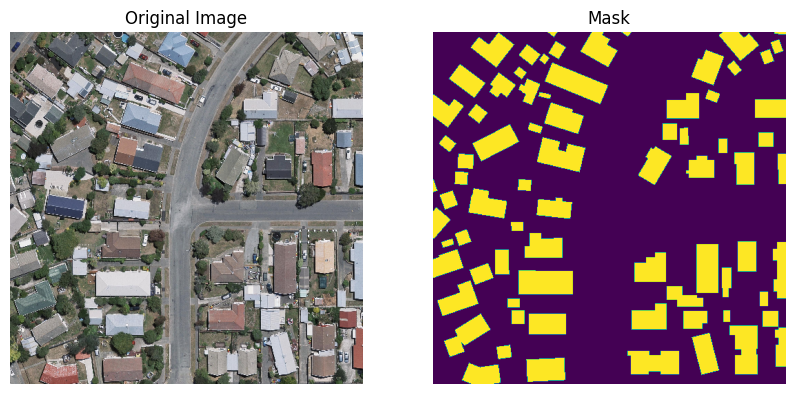

In [16]:
mask = mask.unsqueeze(dim = 0).permute(1 , 2 , 0)
mask = mask.numpy()
img = image.permute(1 , 2 , 0)
img = img.numpy()

fig , axs = plt.subplots(nrows = 1 , ncols = 2 , figsize = (10 , 10))
axs[0].imshow(img)
axs[0].set_title("Original Image")
axs[0].axis('off')
axs[1].imshow(mask)
axs[1].set_title("Mask")
axs[1].axis('off')
plt.show()


In [17]:
model = Segmentor().to(device)
summary(model , input_size=( 3 , 512 , 512))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 510, 510]           1,792
              ReLU-2         [-1, 64, 510, 510]               0
       BatchNorm2d-3         [-1, 64, 510, 510]             128
            Conv2d-4         [-1, 96, 508, 508]          55,392
              ReLU-5         [-1, 96, 508, 508]               0
       BatchNorm2d-6         [-1, 96, 508, 508]             192
         MaxPool2d-7         [-1, 96, 254, 254]               0
            Conv2d-8        [-1, 128, 252, 252]         110,720
              ReLU-9        [-1, 128, 252, 252]               0
      BatchNorm2d-10        [-1, 128, 252, 252]             256
           Conv2d-11        [-1, 256, 250, 250]         295,168
             ReLU-12        [-1, 256, 250, 250]               0
      BatchNorm2d-13        [-1, 256, 250, 250]             512
        MaxPool2d-14        [-1, 256, 1

Training

In [ ]:
train_loss , val_loss  = train_val(model = model , 
                                                        train_loader = train_loader, 
                                                        val_loader = val_loader, 
                                                        epochs = epochs, 
                                                        lr = lr, 
                                                        device = device , 
                                                        lr_schedule=scheduler , 
                                                        out_dir = "weights/resume" ,
                                                        neptune_config="../neptune.json",
                                                        pretrain_checkpoint="weights/best_checkpoint.pth", 
                                                        )

In [ ]:
test_results = test(model , test_loader=test_loader , checkpoint = "weights/resume/best_checkpoint.pth" , 
                             device = device,
                             output_dir= "results" , 
                             name = "results_mass" , 
                             postprocessing=True)

length of test dataset:402 batches
outputs shape torch.Size([6, 1, 512, 512])


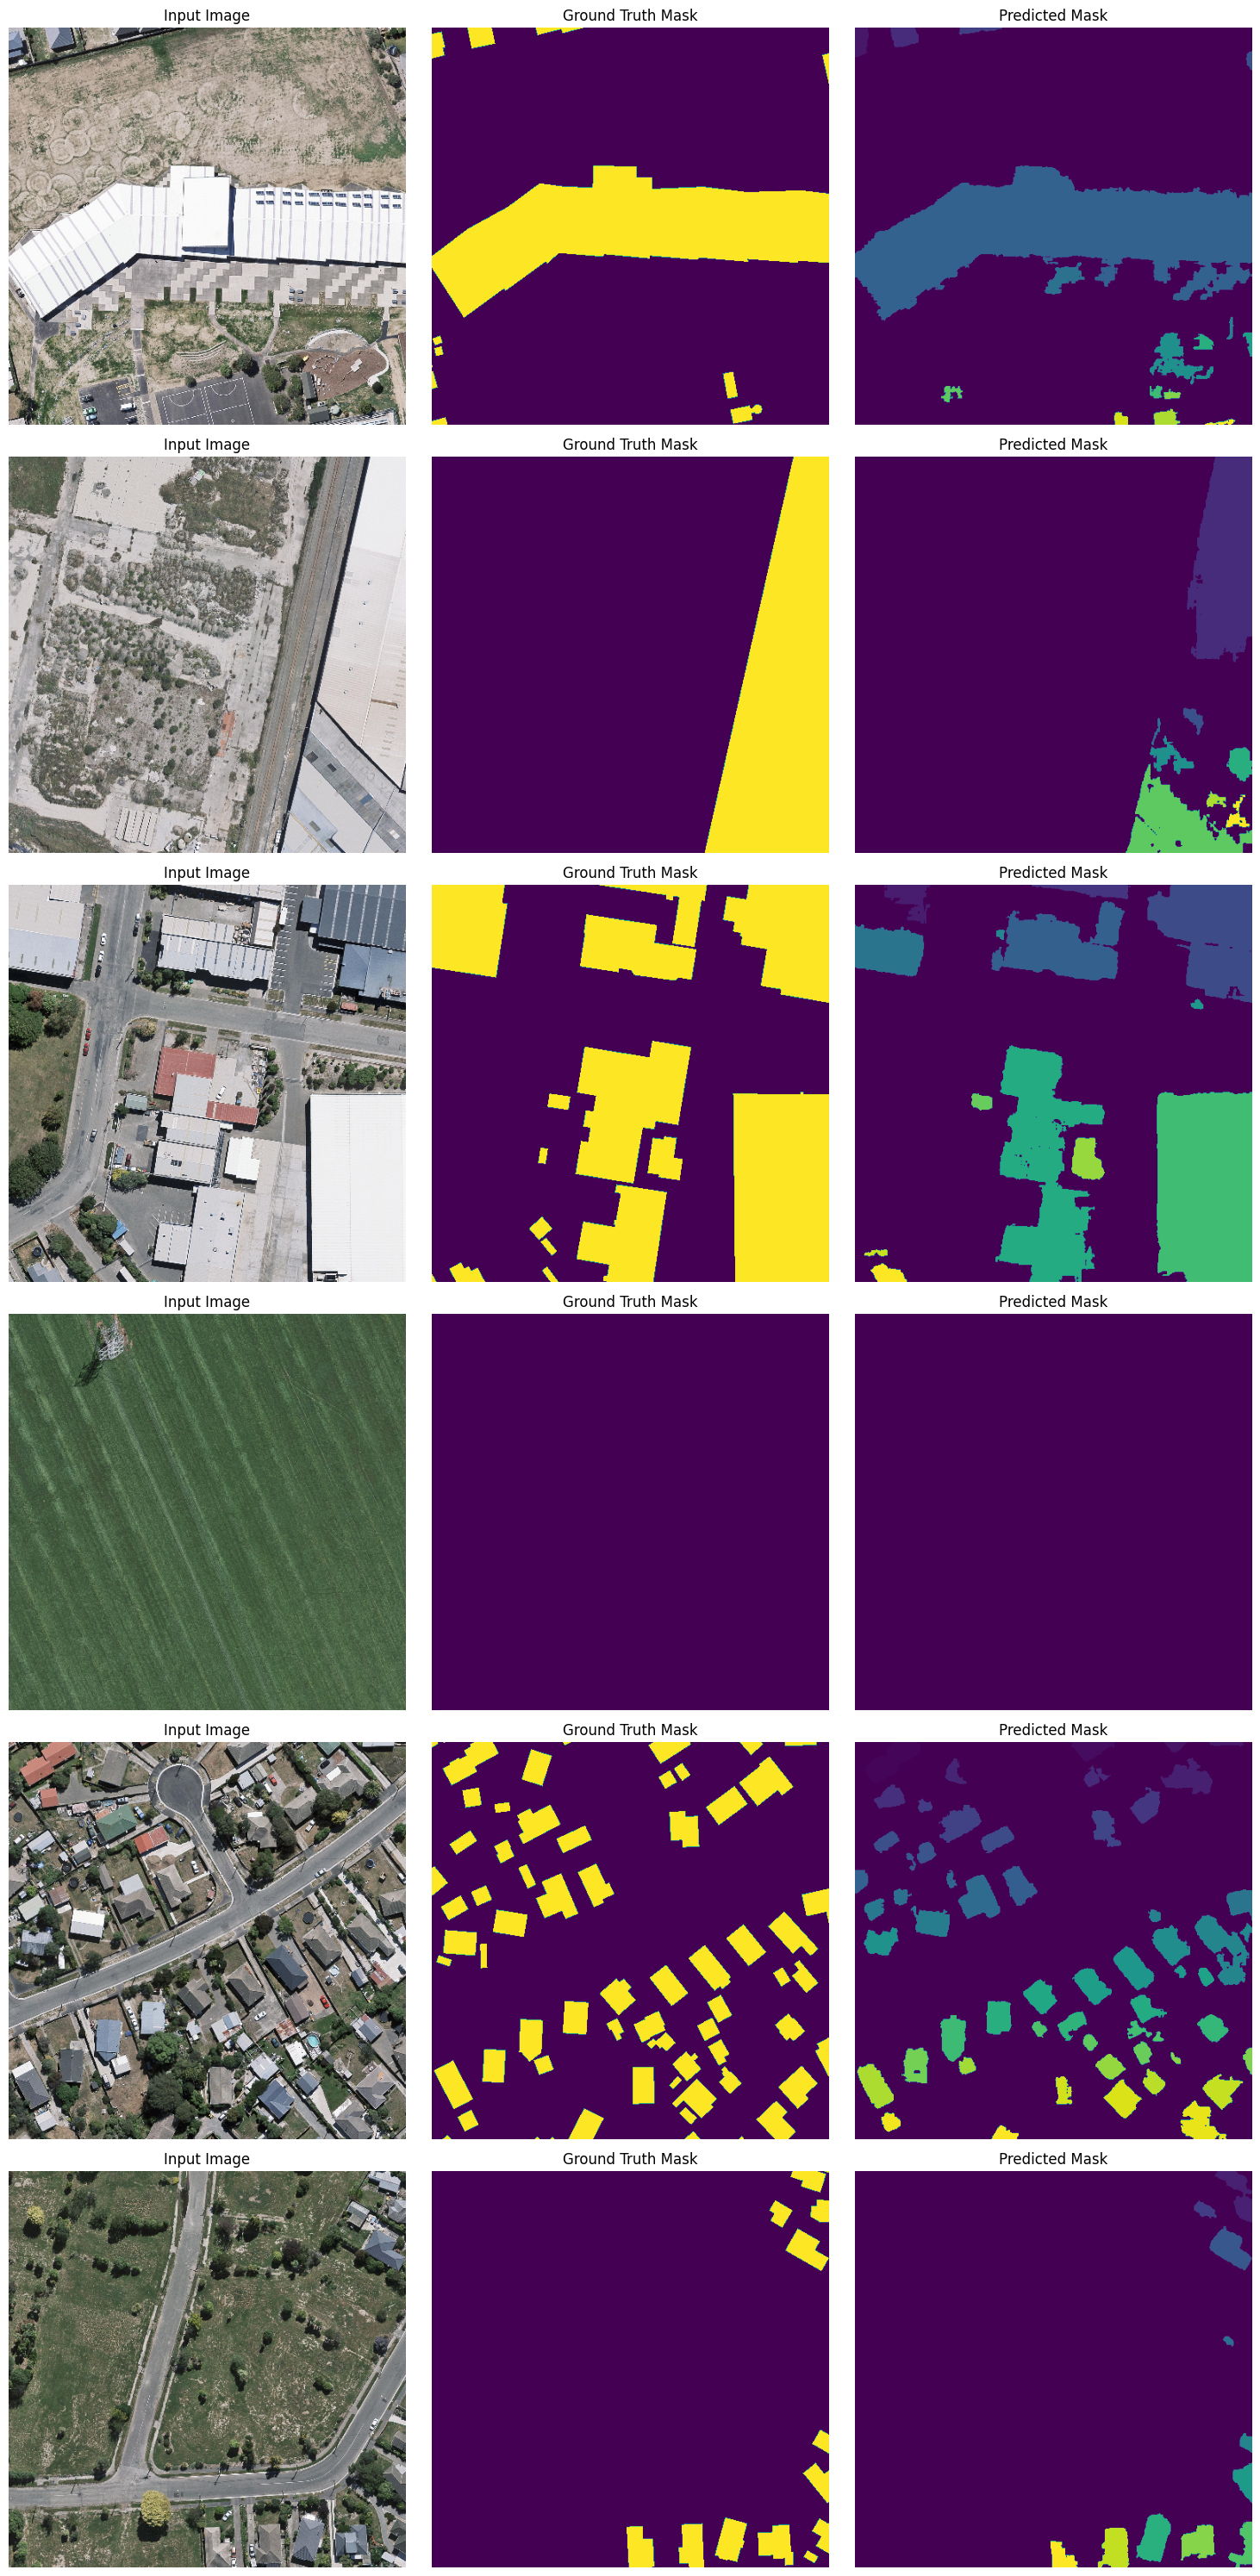

In [18]:
print(f"length of test dataset:{len(test_loader)} batches")
test_iter = iter(test_loader)
batch_numb = 2 #starts from zero
for i in range(batch_numb):
    batch = next(test_iter)
    images , masks = batch
#3
# batch = next(test_iter)
# images , masks = batch

#images --> [batch, 3 , 512 , 512]    / masks --> [batch , 1 , 512 , 512]
# pred_masks --> outputs --> [batch , 1 , 512 , 512]
plot(model = model , images = images , gt_masks = masks , checkpoint="weights/best_checkpoint.pth", device = device , with_postprocess = True)